In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
from torch.jit import script, trace
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn import preprocessing

In [2]:
cwd = os.getcwd()

## Load EEG Data

In [61]:
#eeg_s = [
#    np.load("preprocessed_data_Sandra.npy"),
#    np.load("preprocessed_data_Ethan.npy"),
#]

eeg_s = [
    np.load("preprocessed_data_Sandra.npy")
]

In [62]:
def condense_preprocessed_data(eeg_pre):
    return np.array(
        [
            eeg_pre[i, :, j, :]
            for i in range(23)
            for j in range(eeg_pre.shape[2])
            if np.sum(eeg_pre[i, :, j, :]) != 0
        ]
    )


# Combine all sessions into one array
eeg_data = np.vstack([condense_preprocessed_data(session) for session in eeg_s])

print(eeg_data.shape)

(1676, 8, 750)


## Load VAD/Emotion Labels

In [63]:
emocsv = pd.read_csv("emotion-data/emotion_data.csv")
emocsv1 = emocsv.iloc[:, 5:]

In [64]:
new_cols = ["How feel", "Pos", "Energ", "Dom", "Content", "Amused", "Angry", "Sad", "Disgust", "Afraid", "Emo"]

In [65]:
emo_labels = pd.DataFrame()

for row in range(2):
    sel_row = emocsv1.iloc[row]
    for i in np.arange(0, emocsv1.shape[1], 11):
        obs = sel_row[i : i + 11].to_frame().T
        obs = obs.rename(columns={obs.columns[i]: new_cols[i] for i in range(11)})
        emo_labels = pd.concat([emo_labels, obs])
print(emo_labels)

                                            How feel Pos Energ Dom Content  \
0  disgusted, but the music made the video funny,...   2     3   7       1   
0                                          disgusted   2     3   7       1   
0                                          disgusted   1     5   7       1   
0                                            relaxed   6     5   8       3   
0                                         moved, sad   3     4   3       1   
0                                                sad   2     5   4       1   
0                                         angry, sad   1     6   3       1   
0                                            neutral   5     3   5       1   
0                                              angry   2     5   4       1   
0                                            annoyed   1     5   2       1   
0              a little bit annoyed, overall neutral   3     5   6       1   
0                                            neutral   5     5  

In [66]:
emo_labels['Pos2'] = (emo_labels['Pos'] > 4) + 0
emo_labels['Energ2'] = (emo_labels['Energ'] > 4) + 0
emo_labels['Dom2'] = (emo_labels['Dom'] > 4) + 0

In [67]:
valence = emo_labels['Pos2'].to_numpy()
arousal = emo_labels['Energ2'].to_numpy()
dominance = emo_labels['Dom2'].to_numpy()

In [68]:
y1, y2, y3 = [], [], []  # VAD labels given for each 3-second data chunk

for session_number, session in enumerate(eeg_s):
    for i in range(23):
        j = 0
        while j < session.shape[2] and np.sum(session[i, :, j, :]) != 0:
            idx = i + session_number * 23
            y1.append(valence[idx])
            y2.append(arousal[idx])
            y3.append(dominance[idx])
            j += 1

print(
    len(y1)
)  # this corresponds to the number of 3-second chunks across all data chunks. 1676 -> ~ 4 minutes per video on average, checks out

1676


In [69]:
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

## Create DataLoaders

In [70]:
indices = np.arange(len(eeg_data))
np.random.seed(1)
np.random.shuffle(indices)
indices

array([ 979, 1336,  881, ..., 1096,  235, 1061])

In [73]:
# Define the split ratios
ratios = [0.04, 0.04, 0.02]
train_ratio, valid_ratio, test_ratio = ratios

# Calculate split points
train_end = int(len(indices) * train_ratio)
valid_end = int(len(indices) * (train_ratio + valid_ratio))
test_end = int(len(indices) * (train_ratio + valid_ratio + test_ratio))

# Split the indices
train_indices, valid_indices, test_indices = (
    indices[:train_end],
    indices[train_end:valid_end],
    indices[valid_end:test_end],
)

# Print lengths of each split
print(
    f"Total: {len(indices)}, Train: {len(train_indices)}, Validation: {len(valid_indices)}, Test: {len(test_indices)}"
)

Total: 1676, Train: 67, Validation: 67, Test: 33


In [74]:
x_train = eeg_data[train_indices]
y_train_v = y1[train_indices]
y_train_a = y2[train_indices]
y_train_d = y3[train_indices]

x_valid = eeg_data[valid_indices]
y_valid_v = y1[valid_indices]
y_valid_a = y2[valid_indices]
y_valid_d = y3[valid_indices]

x_test = eeg_data[test_indices]
y_test_v = y1[test_indices]
y_test_a = y2[test_indices]
y_test_d = y3[test_indices]

In [75]:
train_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_v))
val_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_v))
test_dataset_v = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_v))

train_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_a))
val_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_a))
test_dataset_a = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_a))

train_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_d))
val_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_d))
test_dataset_d = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_d))


bsz = 50

train_loader_v = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_v = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_v = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

train_loader_a = torch.utils.data.DataLoader(train_subset_a, shuffle=True, batch_size=bsz)
val_loader_a = torch.utils.data.DataLoader(val_subset_a, shuffle=False, batch_size=bsz)
test_loader_a = torch.utils.data.DataLoader(test_dataset_a, shuffle=False, batch_size=bsz)

train_loader_d = torch.utils.data.DataLoader(train_subset_d, shuffle=True, batch_size=bsz)
val_loader_d = torch.utils.data.DataLoader(val_subset_d, shuffle=False, batch_size=bsz)
test_loader_d = torch.utils.data.DataLoader(test_dataset_d, shuffle=False, batch_size=bsz)

## Neural Network

In [76]:
samp_time = 750
n_channels = 8

In [77]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [78]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
v_net = CNN_LSTM()
print(v_net.forward(Variable(input_tensor)))
v_criterion = nn.CrossEntropyLoss() # add to device here
v_optimizer = optim.Adam(v_net.parameters(), lr=0.001, weight_decay=1e-7)

a_net = CNN_LSTM()
a_criterion = nn.CrossEntropyLoss() # add to device here
a_optimizer = optim.Adam(a_net.parameters(), lr=0.001, weight_decay=1e-7)

d_net = CNN_LSTM()
d_criterion = nn.CrossEntropyLoss() # add to device here
d_optimizer = optim.Adam(d_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.7430, 0.2570]], grad_fn=<SoftmaxBackward0>)


In [79]:
def train_net(net, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_hist = []
    val_hist = []

    for epoch_idx in tqdm(range(num_epochs)):
        net.train()
        train_count = 0
        train_correct_count = 0
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float()
            train_y = train_y.long()
            optimizer.zero_grad()
            logits = net(train_x)
            loss = criterion(logits, train_y)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_hist.append(train_acc)

        net.eval()
        val_count = 0
        val_correct_count = 0
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float()
                val_y = val_y.long()
                logits = net(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)
                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_x.size(0)
        val_acc = val_correct_count / val_count
        val_hist.append(val_acc)
        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

    plt.plot(train_hist)
    plt.plot(val_hist)

In [80]:
def eval_net(net, test_loader):
    net.eval()
    test_count = 0
    test_correct_count = 0
    with torch.no_grad():
        for idx, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float()
            test_y = test_y.long()
            logits = net(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)
    test_acc = test_correct_count / test_count

    print('Test acc: {:.10f}'.format(test_acc))

 10%|█         | 5/50 [00:00<00:02, 22.16it/s]

Train acc: 0.448, Val acc: 0.552
Train acc: 0.657, Val acc: 0.552
Train acc: 0.627, Val acc: 0.552
Train acc: 0.612, Val acc: 0.552
Train acc: 0.612, Val acc: 0.582
Train acc: 0.612, Val acc: 0.612


 22%|██▏       | 11/50 [00:00<00:01, 23.75it/s]

Train acc: 0.687, Val acc: 0.642
Train acc: 0.612, Val acc: 0.687
Train acc: 0.657, Val acc: 0.657
Train acc: 0.597, Val acc: 0.672
Train acc: 0.731, Val acc: 0.627


 28%|██▊       | 14/50 [00:00<00:01, 23.65it/s]

Train acc: 0.657, Val acc: 0.672
Train acc: 0.657, Val acc: 0.687
Train acc: 0.612, Val acc: 0.672
Train acc: 0.746, Val acc: 0.627


 40%|████      | 20/50 [00:00<00:01, 21.61it/s]

Train acc: 0.701, Val acc: 0.627
Train acc: 0.642, Val acc: 0.627
Train acc: 0.701, Val acc: 0.627
Train acc: 0.806, Val acc: 0.687
Train acc: 0.791, Val acc: 0.731


 46%|████▌     | 23/50 [00:01<00:01, 22.34it/s]

Train acc: 0.821, Val acc: 0.731
Train acc: 0.687, Val acc: 0.716
Train acc: 0.731, Val acc: 0.701
Train acc: 0.716, Val acc: 0.716
Train acc: 0.761, Val acc: 0.746


 58%|█████▊    | 29/50 [00:01<00:00, 23.34it/s]

Train acc: 0.746, Val acc: 0.746
Train acc: 0.746, Val acc: 0.761
Train acc: 0.731, Val acc: 0.761
Train acc: 0.687, Val acc: 0.761
Train acc: 0.761, Val acc: 0.761


 70%|███████   | 35/50 [00:01<00:00, 23.80it/s]

Train acc: 0.791, Val acc: 0.776
Train acc: 0.806, Val acc: 0.761
Train acc: 0.746, Val acc: 0.776
Train acc: 0.746, Val acc: 0.806
Train acc: 0.687, Val acc: 0.791


 76%|███████▌  | 38/50 [00:01<00:00, 24.52it/s]

Train acc: 0.746, Val acc: 0.776
Train acc: 0.716, Val acc: 0.791
Train acc: 0.746, Val acc: 0.791
Train acc: 0.776, Val acc: 0.776


 88%|████████▊ | 44/50 [00:01<00:00, 22.67it/s]

Train acc: 0.687, Val acc: 0.806
Train acc: 0.791, Val acc: 0.791
Train acc: 0.821, Val acc: 0.791
Train acc: 0.746, Val acc: 0.791
Train acc: 0.731, Val acc: 0.791


 94%|█████████▍| 47/50 [00:02<00:00, 23.11it/s]

Train acc: 0.746, Val acc: 0.791
Train acc: 0.746, Val acc: 0.791
Train acc: 0.761, Val acc: 0.791
Train acc: 0.776, Val acc: 0.791
Train acc: 0.806, Val acc: 0.791


100%|██████████| 50/50 [00:02<00:00, 22.87it/s]


Train acc: 0.761, Val acc: 0.776


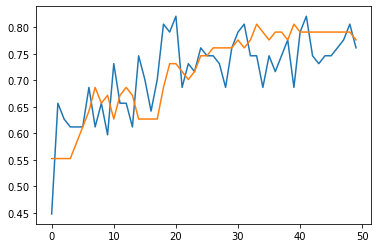

In [81]:
train_net(v_net, v_optimizer, v_criterion, train_loader_v, val_loader_v, 50)

In [82]:
eval_net(v_net, test_loader_v)

Test acc: 0.9393939376


 10%|█         | 5/50 [00:00<00:02, 22.23it/s]

Train acc: 0.552, Val acc: 0.582
Train acc: 0.672, Val acc: 0.582
Train acc: 0.701, Val acc: 0.582
Train acc: 0.687, Val acc: 0.582
Train acc: 0.687, Val acc: 0.582
Train acc: 0.687, Val acc: 0.582


 22%|██▏       | 11/50 [00:00<00:01, 21.48it/s]

Train acc: 0.701, Val acc: 0.582
Train acc: 0.687, Val acc: 0.582
Train acc: 0.701, Val acc: 0.582
Train acc: 0.731, Val acc: 0.612
Train acc: 0.761, Val acc: 0.612


 28%|██▊       | 14/50 [00:00<00:01, 22.80it/s]

Train acc: 0.761, Val acc: 0.657
Train acc: 0.731, Val acc: 0.657
Train acc: 0.716, Val acc: 0.672
Train acc: 0.806, Val acc: 0.672
Train acc: 0.776, Val acc: 0.672


 40%|████      | 20/50 [00:00<00:01, 23.06it/s]

Train acc: 0.776, Val acc: 0.672
Train acc: 0.761, Val acc: 0.672
Train acc: 0.806, Val acc: 0.672
Train acc: 0.836, Val acc: 0.672
Train acc: 0.746, Val acc: 0.672


 52%|█████▏    | 26/50 [00:01<00:01, 23.22it/s]

Train acc: 0.821, Val acc: 0.672
Train acc: 0.896, Val acc: 0.672
Train acc: 0.851, Val acc: 0.672
Train acc: 0.836, Val acc: 0.687
Train acc: 0.821, Val acc: 0.731


 58%|█████▊    | 29/50 [00:01<00:01, 20.36it/s]

Train acc: 0.866, Val acc: 0.731
Train acc: 0.821, Val acc: 0.687
Train acc: 0.866, Val acc: 0.672
Train acc: 0.836, Val acc: 0.672
Train acc: 0.881, Val acc: 0.672


 70%|███████   | 35/50 [00:01<00:00, 21.92it/s]

Train acc: 0.851, Val acc: 0.716
Train acc: 0.881, Val acc: 0.716
Train acc: 0.881, Val acc: 0.761
Train acc: 0.836, Val acc: 0.746
Train acc: 0.925, Val acc: 0.716


 82%|████████▏ | 41/50 [00:01<00:00, 22.66it/s]

Train acc: 0.881, Val acc: 0.761
Train acc: 0.851, Val acc: 0.776
Train acc: 0.896, Val acc: 0.836
Train acc: 0.881, Val acc: 0.836
Train acc: 0.910, Val acc: 0.776


 88%|████████▊ | 44/50 [00:01<00:00, 23.18it/s]

Train acc: 0.881, Val acc: 0.657
Train acc: 0.866, Val acc: 0.672
Train acc: 0.866, Val acc: 0.657
Train acc: 0.896, Val acc: 0.836
Train acc: 0.910, Val acc: 0.851


100%|██████████| 50/50 [00:02<00:00, 21.78it/s]

Train acc: 0.940, Val acc: 0.806
Train acc: 0.925, Val acc: 0.716
Train acc: 0.910, Val acc: 0.716
Train acc: 0.925, Val acc: 0.821


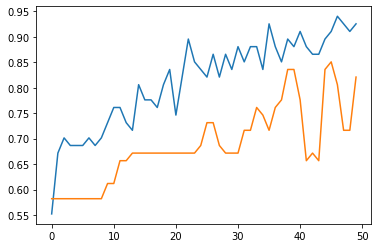

In [83]:
train_net(a_net, a_optimizer, a_criterion, train_loader_a, val_loader_a, 50)

In [84]:
eval_net(a_net, test_loader_a)

Test acc: 0.7878788114


  8%|▊         | 4/50 [00:00<00:02, 17.74it/s]

Train acc: 0.522, Val acc: 0.731
Train acc: 0.687, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716


 14%|█▍        | 7/50 [00:00<00:02, 20.57it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 26%|██▌       | 13/50 [00:00<00:01, 23.48it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 38%|███▊      | 19/50 [00:00<00:01, 24.18it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 50%|█████     | 25/50 [00:01<00:01, 24.24it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 56%|█████▌    | 28/50 [00:01<00:01, 20.62it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 68%|██████▊   | 34/50 [00:01<00:00, 21.39it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 74%|███████▍  | 37/50 [00:01<00:00, 22.10it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 86%|████████▌ | 43/50 [00:01<00:00, 21.64it/s]

Train acc: 0.701, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.761, Val acc: 0.731


 92%|█████████▏| 46/50 [00:02<00:00, 21.99it/s]

Train acc: 0.791, Val acc: 0.731
Train acc: 0.731, Val acc: 0.761
Train acc: 0.687, Val acc: 0.776
Train acc: 0.687, Val acc: 0.761


100%|██████████| 50/50 [00:02<00:00, 21.79it/s]

Train acc: 0.746, Val acc: 0.761
Train acc: 0.731, Val acc: 0.761


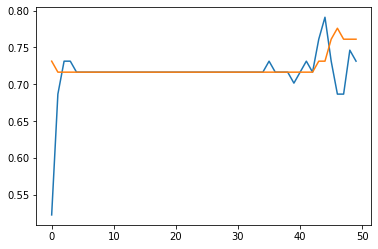

In [85]:
train_net(d_net, d_optimizer, d_criterion, train_loader_d, val_loader_d, 50)

In [86]:
eval_net(d_net, test_loader_d)

Test acc: 0.8484848738


## Saving Nets

In [54]:
torch.save(v_net.state_dict(), cwd + '/vnet')

In [58]:
torch.save(a_net.state_dict(), cwd + '/anet')

In [59]:
torch.save(d_net.state_dict(), cwd + 'dnet')

In [55]:
tester = CNN_LSTM()
tester.load_state_dict(torch.load(cwd + '/vnet'))

<All keys matched successfully>

## Emotions (for later)

In [93]:
class CNN_LSTM2(nn.Module):
    def __init__(self):
        super(CNN_LSTM2, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [107]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
emo_net = CNN_LSTM2()
print(emo_net.forward(Variable(input_tensor)))
e_criterion = nn.CrossEntropyLoss() # add to device here
e_optimizer = optim.Adam(emo_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.1613, 0.0997, 0.3030, 0.1494, 0.0997, 0.1868]],
       grad_fn=<SoftmaxBackward0>)


In [96]:
formal_emotions = emo_labels['Emo']
formal_emotions = formal_emotions.to_numpy()

In [97]:
formal_emotions = formal_emotions.reshape((formal_emotions.size, 1))

In [99]:
from sklearn.preprocessing import OneHotEncoder
cat = OneHotEncoder()
emotions_onehot = cat.fit_transform(formal_emotions).toarray()

In [100]:
emotion_labels = []
for i in range(23):
    j = 0
    while (j < 211 and np.sum(eeg_s1[i,:,j,:])):
        emotion_labels.append(emotions_onehot[i])
        j += 1
print(len(emotion_labels))

1676


In [101]:
emotion_labels = np.array(emotion_labels)

In [105]:
y_train_e = emotion_labels[train_indices]
y_valid_e = emotion_labels[valid_indices]
y_test_e = emotion_labels[test_indices]

In [106]:
train_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_e))
val_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_e))
test_dataset_e = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_e))

train_loader_e = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_e = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_e = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

  2%|▏         | 1/50 [00:01<01:33,  1.91s/it]

Train acc: 0.521, Val acc: 0.693


  4%|▍         | 2/50 [00:03<01:28,  1.84s/it]

Train acc: 0.754, Val acc: 0.823


  6%|▌         | 3/50 [00:05<01:22,  1.75s/it]

Train acc: 0.878, Val acc: 0.849


  8%|▊         | 4/50 [00:06<01:17,  1.69s/it]

Train acc: 0.946, Val acc: 0.903


 10%|█         | 5/50 [00:08<01:15,  1.68s/it]

Train acc: 0.984, Val acc: 0.981


 12%|█▏        | 6/50 [00:10<01:13,  1.66s/it]

Train acc: 0.999, Val acc: 0.973


 14%|█▍        | 7/50 [00:11<01:10,  1.64s/it]

Train acc: 0.999, Val acc: 0.994


 16%|█▌        | 8/50 [00:13<01:09,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 18%|█▊        | 9/50 [00:15<01:08,  1.67s/it]

Train acc: 1.000, Val acc: 0.996


 20%|██        | 10/50 [00:16<01:07,  1.68s/it]

Train acc: 1.000, Val acc: 0.981


 22%|██▏       | 11/50 [00:18<01:04,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 24%|██▍       | 12/50 [00:20<01:02,  1.65s/it]

Train acc: 1.000, Val acc: 1.000


 26%|██▌       | 13/50 [00:21<01:00,  1.62s/it]

Train acc: 1.000, Val acc: 0.994


 28%|██▊       | 14/50 [00:24<01:06,  1.84s/it]

Train acc: 1.000, Val acc: 1.000


 30%|███       | 15/50 [00:26<01:05,  1.88s/it]

Train acc: 1.000, Val acc: 1.000


 32%|███▏      | 16/50 [00:27<01:03,  1.87s/it]

Train acc: 1.000, Val acc: 0.997


 34%|███▍      | 17/50 [00:29<00:59,  1.80s/it]

Train acc: 1.000, Val acc: 1.000


 36%|███▌      | 18/50 [00:31<00:56,  1.76s/it]

Train acc: 1.000, Val acc: 1.000


 38%|███▊      | 19/50 [00:32<00:53,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 40%|████      | 20/50 [00:34<00:50,  1.69s/it]

Train acc: 1.000, Val acc: 0.997


 42%|████▏     | 21/50 [00:35<00:47,  1.64s/it]

Train acc: 1.000, Val acc: 0.993


 44%|████▍     | 22/50 [00:37<00:45,  1.63s/it]

Train acc: 1.000, Val acc: 0.981


 46%|████▌     | 23/50 [00:39<00:44,  1.64s/it]

Train acc: 1.000, Val acc: 0.988


 48%|████▊     | 24/50 [00:40<00:41,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 50%|█████     | 25/50 [00:42<00:39,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 52%|█████▏    | 26/50 [00:43<00:38,  1.59s/it]

Train acc: 1.000, Val acc: 0.997


 54%|█████▍    | 27/50 [00:45<00:37,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 56%|█████▌    | 28/50 [00:47<00:35,  1.61s/it]

Train acc: 1.000, Val acc: 0.997


 58%|█████▊    | 29/50 [00:48<00:34,  1.66s/it]

Train acc: 1.000, Val acc: 1.000


 60%|██████    | 30/50 [00:50<00:33,  1.68s/it]

Train acc: 1.000, Val acc: 0.997


 62%|██████▏   | 31/50 [00:53<00:38,  2.03s/it]

Train acc: 1.000, Val acc: 1.000


 64%|██████▍   | 32/50 [00:56<00:40,  2.23s/it]

Train acc: 1.000, Val acc: 0.997


 66%|██████▌   | 33/50 [00:57<00:35,  2.08s/it]

Train acc: 1.000, Val acc: 1.000


 68%|██████▊   | 34/50 [00:59<00:31,  1.95s/it]

Train acc: 1.000, Val acc: 1.000


 70%|███████   | 35/50 [01:01<00:27,  1.86s/it]

Train acc: 1.000, Val acc: 0.997


 72%|███████▏  | 36/50 [01:02<00:25,  1.82s/it]

Train acc: 1.000, Val acc: 1.000


 74%|███████▍  | 37/50 [01:04<00:22,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 76%|███████▌  | 38/50 [01:05<00:20,  1.68s/it]

Train acc: 1.000, Val acc: 0.988


 78%|███████▊  | 39/50 [01:07<00:18,  1.67s/it]

Train acc: 1.000, Val acc: 0.963


 80%|████████  | 40/50 [01:09<00:16,  1.66s/it]

Train acc: 0.991, Val acc: 0.917


 82%|████████▏ | 41/50 [01:10<00:14,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 84%|████████▍ | 42/50 [01:12<00:12,  1.62s/it]

Train acc: 0.996, Val acc: 1.000


 86%|████████▌ | 43/50 [01:14<00:11,  1.69s/it]

Train acc: 1.000, Val acc: 0.975


 88%|████████▊ | 44/50 [01:16<00:10,  1.70s/it]

Train acc: 0.999, Val acc: 0.991


 90%|█████████ | 45/50 [01:17<00:08,  1.68s/it]

Train acc: 0.996, Val acc: 0.960


 92%|█████████▏| 46/50 [01:19<00:06,  1.61s/it]

Train acc: 0.988, Val acc: 0.963


 94%|█████████▍| 47/50 [01:20<00:05,  1.69s/it]

Train acc: 0.999, Val acc: 1.000


 96%|█████████▌| 48/50 [01:22<00:03,  1.70s/it]

Train acc: 1.000, Val acc: 0.987


 98%|█████████▊| 49/50 [01:24<00:01,  1.87s/it]

Train acc: 0.999, Val acc: 0.985


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]

Train acc: 0.997, Val acc: 1.000


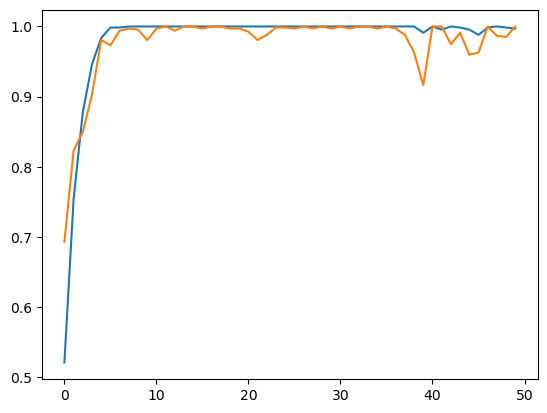

In [108]:
train_net(emo_net, e_optimizer, e_criterion, train_loader_e, val_loader_e, 50)

In [109]:
eval_net(emo_net, test_loader_e)

Test acc: 1.0000000000
